In [1]:
#Projet

## Question 1

*Approximate the integral of f using standard Monte Carlo and quasi-Monte Carlo,
and compare the results, for different values of d (and different Monte Carlo sample
sizes!).*

**A. Monte-Carlo standard**

In [2]:
#!pip install qmcpy
!pip install pyDOE

In [3]:
#imporation des modules nécessaires
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol

In [4]:
#définition de la fonction target f

def f(u):
    d = u.shape[1] 
    return 1 + np.sin(2 * np.pi * (1/d * np.sum(u, axis = 1) - 1/2))

def f2D(u,v):
    d = 2
    return 1 + np.sin(2 * np.pi * (1/d * (u+v) - 1/2))

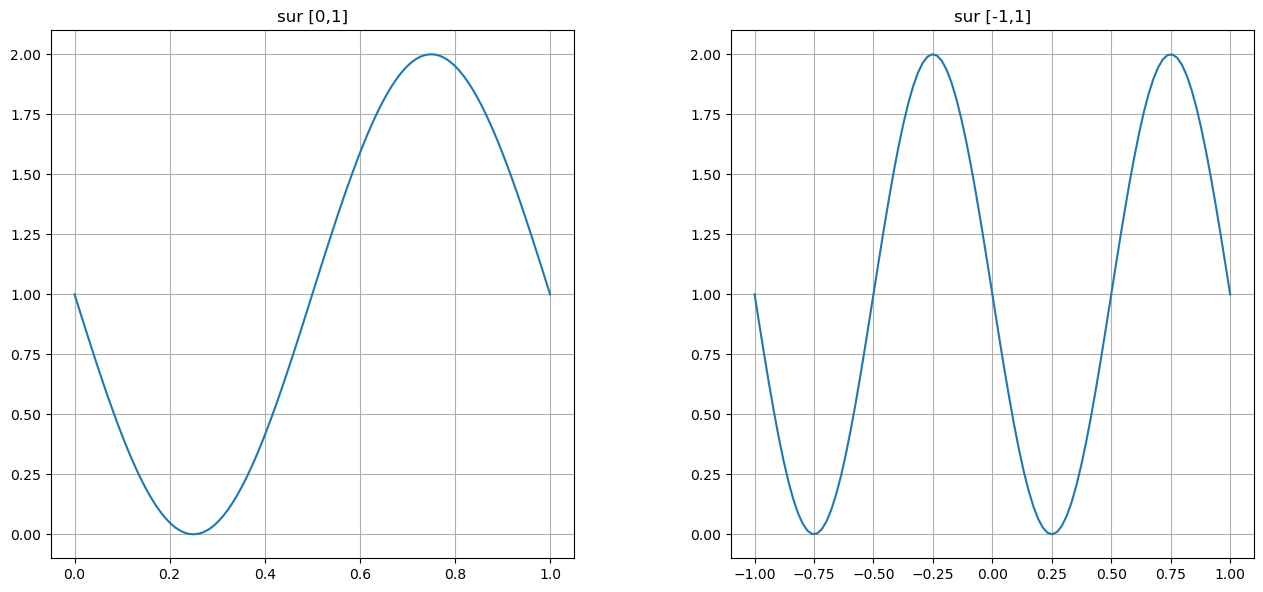

In [5]:
#Visualisation de la fonction target pour d = 1

plt.subplot(1,2,1)
u = np.linspace(0, 1, num=100)
y = 1 + np.sin(2 * np.pi * (u - 1/2))
plt.plot(u,y)
plt.grid()
plt.title("sur [0,1]")

plt.subplot(1,2,2)
u = np.linspace(-1, 1, num=100)
y = 1 + np.sin(2 * np.pi * (u - 1/2))
plt.plot(u,y)
plt.grid()
plt.title("sur [-1,1]")

plt.gcf().subplots_adjust(left = 0.02, bottom = 0.2, right = 1.9, top = 1.3, wspace = 0.3, hspace = 0.3)

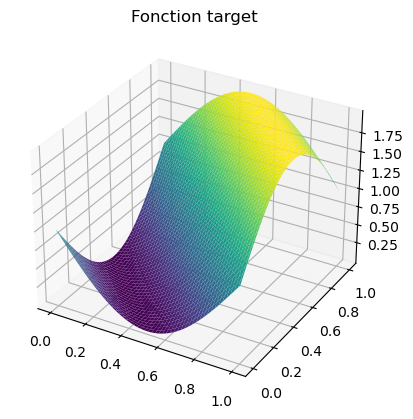

In [6]:
#Visualisation de la fonction target en 3D (pour d = 2)
x1 = np.linspace(0, 1, num=100)
x2 = np.linspace(0, 1, num=100)
X1, X2 = np.meshgrid(x1, x2)
Z = f2D(X1, X2)
fig = plt.figure()
ax = fig.add_subplot(projection='3d') # pour un graphe en 3D
ax.plot_surface(X1, X2, Z, cmap='viridis')
plt.title("Fonction target")
plt.show()


In [7]:
#La fonction est bien C^r([0,1]^d) car la fonction sinus est C^∞ et 1 + x est linéaire.

In [8]:
#Estimation de l'intégrale par la méthode de Monte Carlo standard

def MonteCarlo(f,d,N):
    x = np.random.rand(N, d)   #génération de points aléatoires (uniformes)
    integral = np.sum(f(x))/N  #approximation de l'intégrale
    return(integral)

In [9]:
MonteCarlo(f, N = 100000, d = 3)

1.0018697671603325

**B. Quasi Monte-Carlo**

1. Sobol

In [10]:
#Estimation de l'intégrale par la méthode de Quasi Monte Carlo 

def QuasiMonteCarlo_sob(f, d, N):
    sobol = Sobol(d)              
    u = sobol.random(n = N)       #génération des points quasi-aléatoires
    integral = np.sum(f(u)) / N   #calcul de l'intégrale approximative
    return(integral)

QuasiMonteCarlo_sob(f, N = 2**15, d = 3)

0.9999997146968442

2. Stratification : latin hypercube sampling

*La fonction python lhs() génère un échantillon de points quasi-aléatoires en utilisant la méthode du Latin Hypercube Sampling. Le LHS est une méthode de génération de points quasi-aléatoires qui permet d'obtenir une répartition uniforme des points dans chaque dimension de l'espace d'intégration.*

In [11]:
from pyDOE import lhs
N = 20
d = 2
sample = lhs(n = d, samples = N)

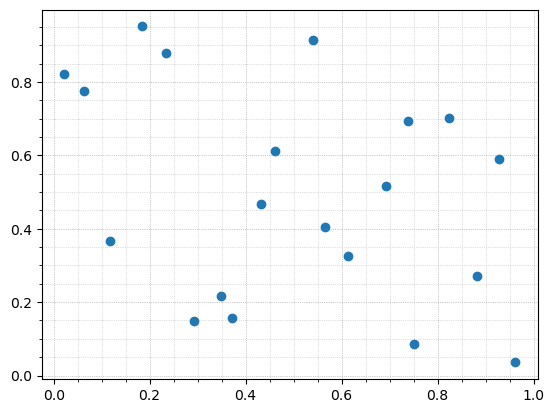

In [12]:
plt.scatter(sample[:,0], sample[:,1])
plt.grid(which='both', axis='both', linewidth=0.5, color='gray', linestyle=':', alpha=0.8)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linewidth=0.5, color='gray', linestyle=':', alpha=0.5)


In [13]:
#On observe bien un point par ligne et par colonne (principe du LHS)

In [14]:
#A partir de cette méthode de génération de points quasi-aléatoire, on peut de nouveau implémenter la méthode Quasi Monte Carlo
def QuasiMonteCarlo_strat(f, d, N):
    samples = lhs(n = d, samples = N) # génération des points quasi-aléatoires avec LHS (latin hypercube sampling)
    integral = np.sum(f(samples)) / N # on évalue la fonction aux points générés et on estime l'intégrale
    return(integral)

QuasiMonteCarlo_strat(f, N = 2**15, d = 3)


1.001721422792205

*Intérêt de la stratification : d'après l'inégalité de Koksma–Hlawka présentée ci-dessous, la précision d'un estimateur dépend de l'uniformité de l'échantillon. L'uniformité est évaluée dans l'inégalité par D*(u1:uN)*.

<img src="Koksma–Hlawka_inequality.png" alt="Drawing" style="width: 400px;"/>

**C. Comparaison**

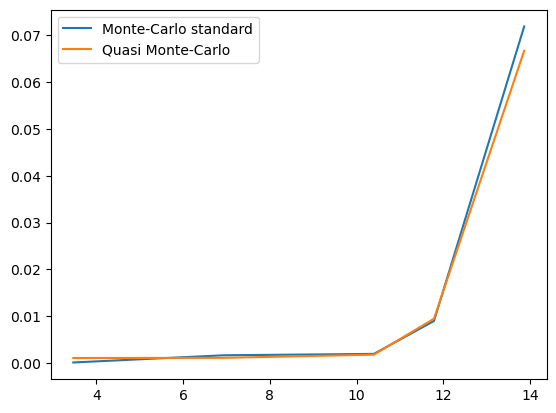

In [15]:
#Temps de calcul
NN = np.array([2**5, 2**10, 2**15, 2**17, 2**20]) #différentes tailles d'échantillons

tempsMCstandard = []
tempsQMC = []

for n in NN :
    start_time = time.time()    
    MonteCarlo(f, N = n, d = 3)                   #appel de la fonction
    end_time = time.time()     
    tempsMCstandard.append(end_time - start_time) #temps de calcul par la méthode Monte Carlo standard
    
    start_time = time.time()
    QuasiMonteCarlo_sob(f, N = n, d = 3)              #appel de la fonction
    end_time = time.time()
    tempsQMC.append(end_time - start_time)        #temps de calcul par la méthode Quasi Monte Carlo 

plt.plot(np.log(NN),tempsMCstandard)              #visualisation des temps de calcul méthode Monte Carlo selon la taille de l'échantillon
plt.plot(np.log(NN),tempsQMC)                     #visualisation des temps de calcul méthode Quasi Monte Carlo selon la taille de l'échantillon
plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])


/tmp/ipykernel_16732/3281318983.py:19: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(NN),np.log(precisionQMC))


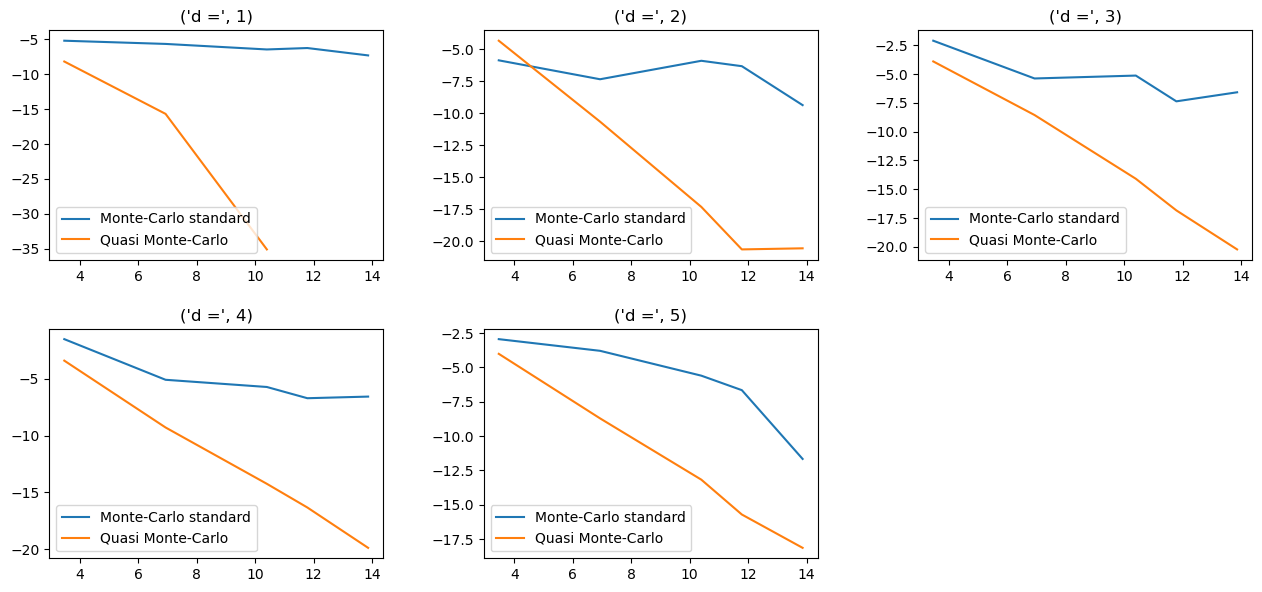

In [16]:
#Précision
NN = np.array([2**5, 2**10, 2**15, 2**17, 2**20]) #différentes tailles d'échantillon
DD = np.arange(1,6) #différentes dimensions d

l = 1
for d in DD:
    precisionMCstandard = []
    precisionQMC = []
    for n in NN :
        y_predict = MonteCarlo(f, N = n, d = d) #appel de la fonction Monte Carlo standard
        precisionMCstandard.append(np.abs((1-y_predict))) #calcul de l'écart |y_pred-y*| avec y* = 1 pour Monte Carlo standard
        
        y_predict = QuasiMonteCarlo_sob(f, N = n, d = d) #appel de la fonction Monte Carlo standard
        precisionQMC.append(np.abs(1-y_predict)) #calcul de l'écart |y_pred-y*| avec y* = 1 pour Quasi Monte Carlo 
    
    #visualisation pour chaque d allant de 1 à 5
    plt.subplot(2,3,l)
    plt.plot(np.log(NN),np.log(precisionMCstandard))
    plt.plot(np.log(NN),np.log(precisionQMC))
    plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])
    plt.title(('d =', d))
    l+=1

plt.gcf().subplots_adjust(left = 0.02, bottom = 0.2, right = 1.9, top = 1.3, wspace = 0.3, hspace = 0.3)
#plt.figure(figsize = (20, 10))

In [17]:
#calcul de l'erreur quadratique moyenne pour N = 2**10
d = 2
N = 2**10
precision_moyenne_MCstandard = np.zeros(100)
precision_moyenne_QMC = np.zeros(100)
estim_MC = np.zeros(100)
estim_QMC = np.zeros(100)
for i in range(100):
    y_predict = MonteCarlo(f, N = N, d = d)
    estim_MC[i] = y_predict
    precision_moyenne_MCstandard[i] = (1-y_predict)**2
    y_predict = QuasiMonteCarlo_sob(f, N = N, d = d)
    estim_QMC[i] = y_predict
    precision_moyenne_QMC[i] = (1-y_predict)**2
    

print("erreur moyenne MC : ", np.mean(precision_moyenne_MCstandard[i]))
print("erreur moyenne QMC : ", np.mean(precision_moyenne_QMC[i]))

print("variance MC : ", np.var(estim_MC))
print("variance QMC : ", np.var(estim_QMC))

erreur moyenne MC :  3.0892900921991046e-07
erreur moyenne QMC :  8.09195940926524e-11
variance MC :  0.0005155247592612119
variance QMC :  2.6734806869495714e-08


In [18]:
#comparaison des erreurs de prédiction des méthodes Monte Carlo et Quasi Monte Carlo
#La méthode Quasi Monte Carlo présente les meilleurs résultats

## Question 2

*Read the introduction of the following paper https://arxiv.org/abs/2210.01554
up to Equations (5) and (6), which introduce Haber’s estimators of order 1 and
2. Implement these two estimators, and compare to the results of Step 1. (Again
consider different values of d and N, where N is the number of evaluations of f).*

In [90]:
#Importation des modules nécessaires
from scipy.integrate import nquad
from scipy.stats import uniform

In [91]:
#calcul des coordonnées des centres de chaque cellule

from itertools import product

def cells_centers(d = 2, n_cells = 5):
    vecteur = np.around(np.linspace(1/(2*n_cells), 1 - 1/(2*n_cells), n_cells), decimals=10) #découpe le segment [0,1] en n_cells points répartis de manière à être une coordonnée du centre des cellules
    cell_coord = product(vecteur, repeat = d) #product donne toutes les combinaisons possibles de groupes de taille d du vecteur en argument 
    cell_coord = np.array(list(map(list, cell_coord))) #changement de type
    return(cell_coord) #product a permis d'avoir toutes les combinaisons possibles du vecteur, ce qui correspond à toutes les coordonnées des centres des hypercubes 

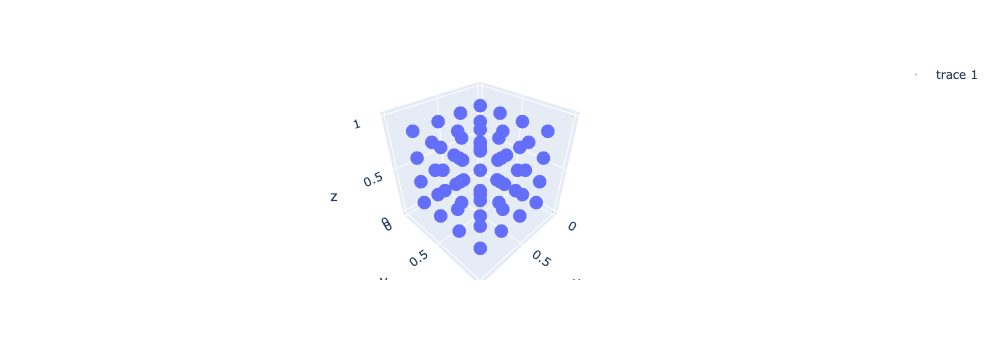

In [92]:
#vérification de la fonction cells_centers_2 pour d = 3
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

#appel à la fonction pour récupérer les coordonnées des centres des cellules 
pts = cells_centers_2(d = 3, n_cells = 4)

#création du dataframe pour le plot
df = pd.DataFrame({'x': pts[:,0], 'y': pts[:,1], 'z': pts[:,2]})

#création du dataframe pour les coins du cube [0,1]^3 (pour afficher l'entiereté de l'hypercube)
df_corners = pd.DataFrame({'x': [0, 1, 1, 0, 0, 1, 1, 0],
                           'y': [0, 0, 1, 1, 0, 0, 1, 1],
                           'z': [0, 0, 0, 0, 1, 1, 1, 1],
                           'text': ['Corner 1', 'Corner 2', 'Corner 3', 'Corner 4', 'Corner 5', 'Corner 6', 'Corner 7', 'Corner 8'],
                           'size': [1]*8,
                           'color': ['black']*8})

#graphe en 3D des centres des cellules
fig = px.scatter_3d(df, x='x', y='y', z='z')

#ajout des points représentant les coins du cube (pour une meilleure visualisation)
fig.add_trace(go.Scatter3d(x=df_corners['x'], y=df_corners['y'], z=df_corners['z'],
                           mode='markers',
                           marker=dict(color=df_corners['color'], size=df_corners['size']),
                           text=df_corners['text']))

fig.show()

In [93]:
#Implémentation de la fonction g, utilisée dans l'estimateur d'Haber d'ordre 2
def g_c(x,c):
    return((f(c + x) + f(c - x))/2)

In [94]:
#Implémentation des estimateurs d'Haber

#génère les points uniformes tels qu'ils sont définis dans le papier (Uc ~U([-1/2k,1/2k]^d)
def generate_haber(n, k, d):
    return(np.random.uniform(low=-1/(2*k), high=1/(2*k), size=(n, d))) 
    
def habers_estimation(f, order, k, d):
    cell_coord = cells_centers(d, n_cells = k)
    U = generate_haber(len(cell_coord), k, d)
    if order == 1:
        f_values = f(cell_coord + U) #évalue f aux centres de chaque hypercube déplacé
    if order == 2:
        f_values = g_c(U, cell_coord) #évalue f aux centres des hypercubes déplacé par l'intermédiaire de la fonction g
    return np.sum(f_values)/k**d #estime ensuite l'intégrale 
    

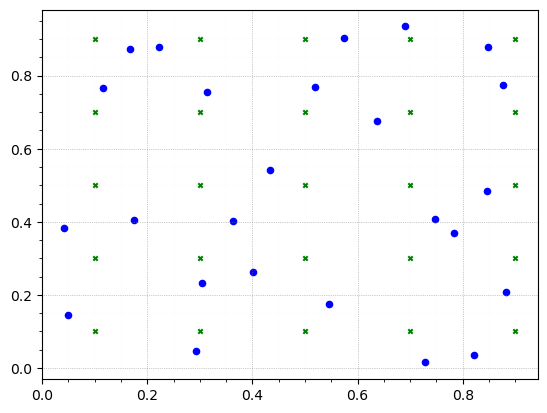

In [95]:
d = 2
k = 5
cell_coord = cells_centers_2(d, n_cells = k)
U = generate_haber(len(cell_coord), k, d)
pts = cell_coord + U
plt.scatter(pts[:,0], pts[:,1], color = 'blue', s = 20)
plt.scatter(cell_coord[:,0], cell_coord[:,1], color = 'green', s = 10, marker = 'x')
plt.grid(which='both', axis='both', linewidth=0.5, color='gray', linestyle=':', alpha=0.8)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linewidth=0.1, color='gray', linestyle=':', alpha=0.1)

In [82]:
#ordre 1 (5^2 = 25 évaluation)
habers_estimation(f, order = 1, k = 5, d = 2)

0.9940052706655337

In [83]:
#ordre 2 (5^2 = 25 évaluations)
habers_estimation(f, order = 2, k = 5, d = 2)

1.0005274892778104

**B. Comparaison**

In [84]:
# Comparaison des méthodes... (on préfere Haber d'ordre 2 quand f est 2 fois continuement différentiable)
#On peut maintenant à priori supprimer cette cellule maintenant
ds = [1, 2, 3]
NN = np.array([2**5, 2**10, 2**15])
result = np.zeros((len(NN), 4))

for d in ds:
    i = 0
    result = np.zeros((len(NN), 4))
    for n in NN:
        k = round(n**(1/d)) #par soucis de calcul puisque qu'on doit spécifier pour Haber le k
        N = k**d #afin qu'on teste tous les estimateurs avec un N égal
        
        mc_result = MonteCarlo(f, d, N)
        qmc_result = QuasiMonteCarlo_sob(f, d, N)
        haber1_result = habers_estimation(f, order = 1, k = k, d = d)
        haber2_result = habers_estimation(f, order = 2, k = k, d = d)

        result[i,0] = mc_result
        result[i,1] = qmc_result
        result[i,2] = haber1_result
        result[i,3] = haber2_result
        i += 1
        
    print(f"d = {d}")
    df_res = pd.DataFrame({'N' : NN, 'MC': result[:,0], 'QMC': result[:,1], 'haber1': result[:,2], 'haber2': result[:,3]})
    df_res = df_res.set_index('N')
    print(df_res, '\n')
        

d = 1
             MC       QMC    haber1    haber2
N                                            
32     0.939968  1.000148  0.997247  1.000147
1024   1.010228  1.000000  0.999989  1.000000
32768  0.999505  1.000000  1.000000  1.000000 

d = 2
             MC       QMC    haber1    haber2
N                                            
32     0.903741  1.009163  1.023411  0.997492
1024   0.963789  0.999980  1.000647  1.000017
32768  1.001031  0.999984  0.999994  1.000000 



/opt/mamba/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.

/opt/mamba/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



d = 3
             MC       QMC    haber1    haber2
N                                            
32     0.978712  0.994114  0.995991  0.992249
1024   0.999974  1.000822  0.998944  0.999791
32768  1.007877  1.000003  0.999904  1.000001 



In [88]:
#calcul de l'erreur moyenne et de la variance pour les 4 estimateurs

result = np.zeros((100,4))
d = 2
N = 2**10

for i in range(100):
    k = round(N**(1/d)) #par soucis de calcul puisque qu'on doit spécifier pour Haber le k
    n = k**d #afin qu'on teste tous les estimateurs avec un N égal
    
    # Estimation pour chaque estimateur
    result[i,0] = MonteCarlo(f, d, n)
    result[i,1] = QuasiMonteCarlo_sob(f, d, n)
    result[i,2] = habers_estimation(f, order = 1, k = k, d = d)
    result[i,3] = habers_estimation(f, order = 2, k = k, d = d)

df_result = pd.DataFrame({'MC': result[:,0], 'QMC': result[:,1], 'haber1': result[:,2], 'haber2': result[:,3]})
df_erreur = np.abs(df_result-1)
df_variance = df_result.var()

# Affichage des moyennes
print("Moyennes des erreurs :\n", df_erreur.mean(), '\n')
print("Variance :\n", df_variance)

Moyennes des erreurs :
 MC        0.015349
QMC       0.000047
haber1    0.000724
haber2    0.000018
dtype: float64 

Variance :
 MC        3.861711e-04
QMC       6.978027e-09
haber1    8.084262e-07
haber2    5.139204e-10
dtype: float64


/opt/mamba/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



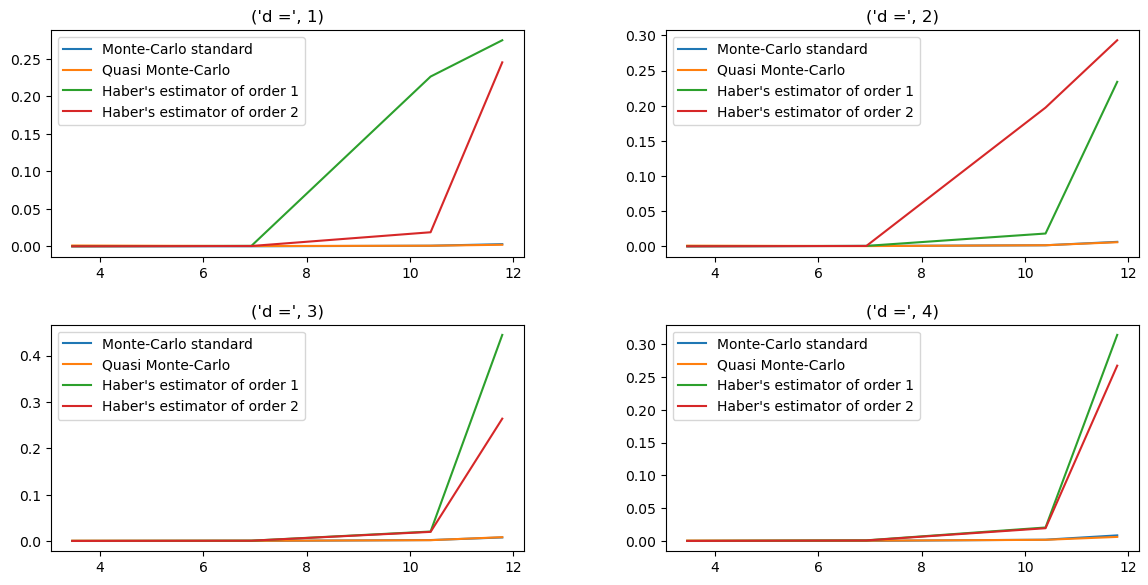

In [89]:
#Comparaison du temps de calcul entre les estimateurs d'Haber d'ordre 1 et 2 avec les méthodes de Montecarlo et de Quasi Monte Carlo
#En fonction de différentes dimensions et de différentes tailles d'échantillons

NN = np.array([2**5, 2**10, 2**15, 2**17]) #différentes tailles d'échantillons
ds = [1, 2, 3, 4]

l = 1
for d in ds :
    tempsMCstandard = []
    tempsQMC = []
    tempsHaber1 = []
    tempsHaber2 = []
    for n in NN :
        k = round(n**(1/d)) #par soucis de calcul puisque qu'on doit spécifier pour Haber le k
        N = k**d #afin qu'on teste tous les estimateurs avec un N égal
        
        start_time = time.time()    
        MonteCarlo(f, N = N, d = d)                   #appel de la fonction
        end_time = time.time()     
        tempsMCstandard.append(end_time - start_time) #temps de calcul par la méthode Monte Carlo standard
    
        start_time = time.time()
        QuasiMonteCarlo_sob(f, N = N, d = d)              #appel de la fonction
        end_time = time.time()
        tempsQMC.append(end_time - start_time)        #temps de calcul par la méthode Quasi Monte Carlo 
    
        start_time = time.time()
        habers_estimation(f, k = k, d = d, order = 1)              #appel de la fonction
        end_time = time.time()
        tempsHaber1.append(end_time - start_time)     #temps de calcul pour la méthode utilisant l'estimateur d'Haber d'ordre 1
    
        start_time = time.time()
        habers_estimation(f, k = k, d = d, order = 2)              #appel de la fonction
        end_time = time.time()
        tempsHaber2.append(end_time - start_time)     #temps de calcul pour la méthode utilisant l'estimateur d'Haber d'ordre 2
    plt.subplot(3,2,l)
    plt.plot(np.log(NN),tempsMCstandard)              #visualisation des temps de calcul méthode Monte Carlo selon la taille de l'échantillon
    plt.plot(np.log(NN),tempsQMC)                     #visualisation des temps de calcul méthode Quasi Monte Carlo selon la taille de l'échantillon
    plt.plot(np.log(NN),tempsHaber1)                     #visualisation des temps de calcul méthode Quasi Monte Carlo selon la taille de l'échantillon
    plt.plot(np.log(NN),tempsHaber2)                     #visualisation des temps de calcul méthode Quasi Monte Carlo selon la taille de l'échantillon
    plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo',"Haber's estimator of order 1", "Haber's estimator of order 2"])
    plt.title(('d =', d))
    l+=1

plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 1.9, top = 1.9, wspace = 0.3, hspace = 0.3)

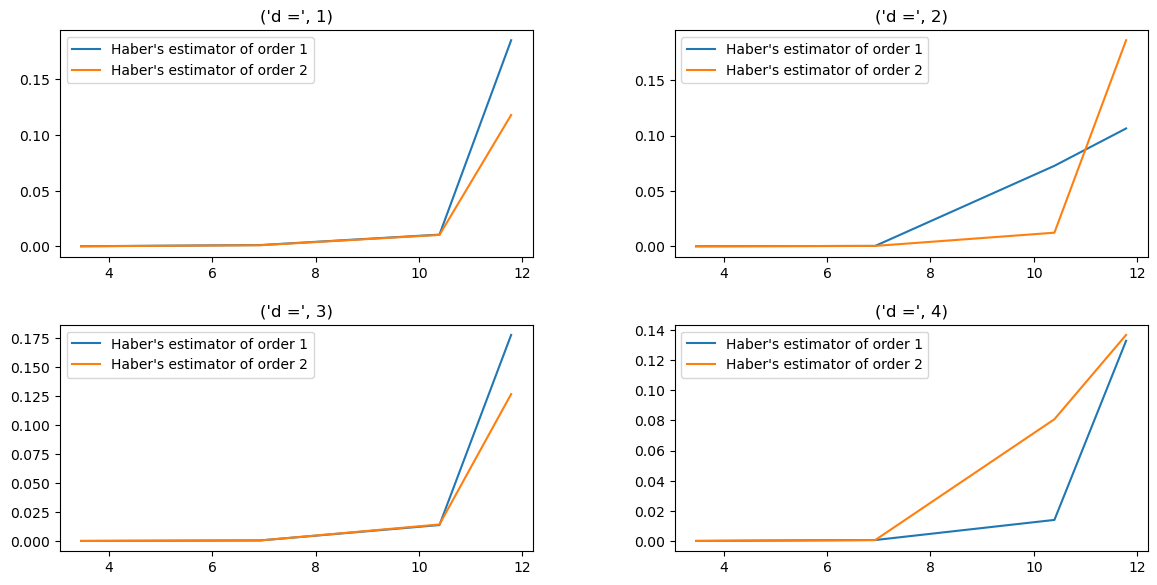

In [29]:
#Comparaison du temps de calcul entre les estimateurs d'Haber d'ordre 1 et 2 visualisation
#En fonction de différentes dimensions et de différentes tailles d'échantillons
#Utile?

NN = np.array([2**5, 2**10, 2**15, 2**17]) #différentes tailles d'échantillons
ds = [1, 2, 3, 4]

l = 1
for d in ds :
    tempsMCstandard = []
    tempsQMC = []
    tempsHaber1 = []
    tempsHaber2 = []
    for n in NN :
        k = round(n**(1/d)) #par soucis de calcul puisque qu'on doit spécifier pour Haber le k

        start_time = time.time()
        habers_estimation(f, k = k, d = d, order = 1)              #appel de la fonction
        end_time = time.time()
        tempsHaber1.append(end_time - start_time)     #temps de calcul pour la méthode utilisant l'estimateur d'Haber d'ordre 1
    
        start_time = time.time()
        habers_estimation(f, k = k, d = d, order = 2)              #appel de la fonction
        end_time = time.time()
        tempsHaber2.append(end_time - start_time)     #temps de calcul pour la méthode utilisant l'estimateur d'Haber d'ordre 2
    plt.subplot(3,2,l)    
    plt.plot(np.log(NN),tempsHaber1)                     #visualisation des temps de calcul méthode Quasi Monte Carlo selon la taille de l'échantillon
    plt.plot(np.log(NN),tempsHaber2)                     #visualisation des temps de calcul méthode Quasi Monte Carlo selon la taille de l'échantillon
    plt.legend(["Haber's estimator of order 1", "Haber's estimator of order 2"])
    plt.title(('d =', d))
    l+=1

plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 1.9, top = 1.9, wspace = 0.3, hspace = 0.3)

/tmp/ipykernel_16732/3709184982.py:32: RuntimeWarning:

divide by zero encountered in log



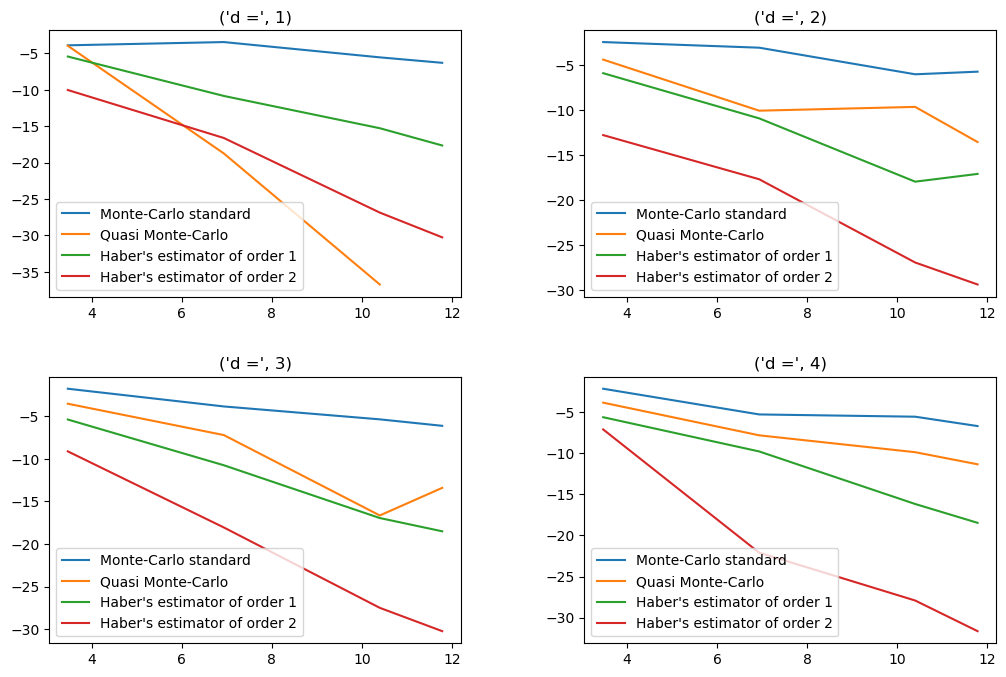

In [30]:
#visualisation précision
#Comparaison de la précision des estimateurs d'Haber d'ordre 1 et 2 avec les méthodes de Monte Carlo et de Quasi Monte Carlo

NN = np.array([2**5, 2**10, 2**15, 2**17]) #différentes tailles d'échantillon
DD = np.arange(1,5) #différentes dimensions d

l = 1
for d in DD:
    precisionMCstandard = []
    precisionQMC = []
    precisionHaber1 = []
    precisionHaber2 = []
    for n in NN :
        k = round(n**(1/d)) #par soucis de calcul puisque qu'on doit spécifier pour Haber le k
        N = k**d #afin qu'on teste tous les estimateurs avec un N égal
        
        y_predict = MonteCarlo(f, N = N, d = d) #appel de la fonction Monte Carlo standard
        precisionMCstandard.append(np.abs((1-y_predict))) #calcul de l'écart |y_pred-y*| avec y* = 1 pour Monte Carlo standard

        y_predict = QuasiMonteCarlo_sob(f, N = N, d = d) #appel de la fonction Quasi Monte Carlo 
        precisionQMC.append(np.abs(1-y_predict)) #calcul de l'écart |y_pred-y*| avec y* = 1 pour Quasi Monte Carlo
        
        y_predict = habers_estimation(f, k = k, d = d, order = 1) #appel de l'estimateur d'Haber d'ordre 1
        precisionHaber1.append(np.abs(1-y_predict)) #calcul de l'écart |y_pred-y*| avec y* = 1 pour l'estimateur d'Haber d'ordre 1
        
        y_predict = habers_estimation(f, k = k, d = d, order = 2) #appel de l'estimateur d'Haber d'ordre 2
        precisionHaber2.append(np.abs(1-y_predict)) #calcul de l'écart |y_pred-y*| avec y* = 1 pour l'estimateur d'Haber d'ordre 1
    
    #visualisation pour chaque d allant de 1 à 5
    plt.subplot(3,2,l)
    plt.plot(np.log(NN),np.log(precisionMCstandard))
    plt.plot(np.log(NN),np.log(precisionQMC))
    plt.plot(np.log(NN),np.log(precisionHaber1))                
    plt.plot(np.log(NN),np.log(precisionHaber2))                
    plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo',"Haber's estimator of order 1", "Haber's estimator of order 2"])
    plt.title(('d =', d))
    l+=1

plt.gcf().subplots_adjust(left = 0.02, bottom = 0.2, right = 1.5, top = 2.2, wspace = 0.3, hspace = 0.3)

In [31]:
#calcul de l'erreur selon les estimateurs et les dimensions

## Question bonus

*Bonus: try to think of an importance sampling approach to obtain a better estimate
of this integral.*

Une distribution d'importance sampling appropriée pour cette fonction f est une distribution qui est proche de la fonction f et qui permet de minimiser la variance de l'estimateur de Monte Carlo.

In [32]:
#Définition de la fonction g (densité que l'on sait simuler facilement)
import scipy.stats as stats
def g(u):
    return(np.all(u >= 0, axis = 1)*np.all(u <= 1, axis = 1)) #densité uniforme sur l'hypercube [0,1]^d

def g2D(u,v):
    return((u>=0)*(v>=0)*(u<=1)*(v<=1))


In [33]:
from scipy.stats import multivariate_normal

def gaussienne(u, mean, cov):
    return(multivariate_normal.pdf(u, mean, cov))

Text(0.5, 0.92, 'densité gaussienne')

<Figure size 640x480 with 0 Axes>

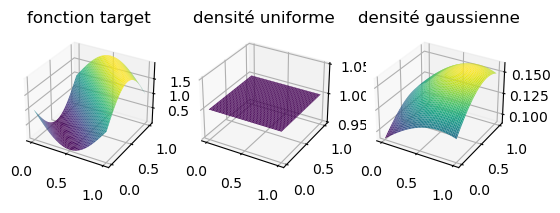

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

#visualisation des 2 densités
x1 = np.linspace(0, 1, num=100)
x2 = np.linspace(0, 1, num=100)
X1, X2 = np.meshgrid(x1, x2)
Z = f2D(X1, X2)
fig = plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, subplot_kw={'projection': '3d'})
ax1.plot_surface(X1, X2, Z, cmap='viridis')
ax1.set_title('fonction target')

x1 = np.linspace(0, 1, num=100)
x2 = np.linspace(0, 1, num=100)
X1, X2 = np.meshgrid(x1, x2)
Z = g2D(X1, X2)
fig = plt.figure()
ax2.plot_surface(X1, X2, Z, cmap='viridis')
ax2.set_title('densité uniforme')

mean = np.array([3/4,3/4])
cov = np.eye(2)
X1, X2 = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
pos = np.empty(X1.shape + (2,))
pos[:, :, 0] = X1
pos[:, :, 1] = X2
Z = multivariate_normal.pdf(pos, mean=mean, cov=cov)
fig = plt.figure()
ax3.plot_surface(X1, X2, Z, cmap='viridis')
ax3.set_title('densité gaussienne')

In [35]:
#avec la densité gaussienne
from scipy.stats import multivariate_normal
   
def gen_normal(N, mu, cov):
    return(np.random.multivariate_normal(mu, cov, N))

def mu_cov_gaussian(d):
    return(np.array([3/4]*d), np.eye(d))

def importance_sampling_gaussian(f, g, N, d):
    mu, cov = mu_cov_gaussian(d)
    u = gen_normal(N, mu, cov)
    weights = f(u)*g(u)/gaussienne(u, mu, cov)
    integral = np.sum(weights)/N
    return integral

importance_sampling_gaussian(f, g, N = 1000000, d = 2)

0.9944552264683302